In [1]:
import numpy as np  # http://www.numpy.org
import matplotlib.pyplot as plt   # http://matplotlib.org
import math as M
from scipy.optimize import fsolve
from scipy.integrate import quad

### Things we need to check:

* our A and Lambert's A are different! We should in general check the dimensions of our basin again

* the perimeter P is in accordance though

* is our value for c still accurate?

* Dx strongly impacts our H1 output, what can we do about this?


In [2]:
############ Initilisation #################
############################################

#### Constants #####
L_x = 1e6          # [m] zonal extent 
L_y = 2e6          # [m] meridional extent 
A = L_x*L_y        # [m^2] surface area of interior 
P = 2*L_x+2*L_y    # [m] Perimeter 

g = 9.81           # [m/s^2] gravitational acceleration 
c_theta = 0.5      # [] eddy coefficient halocline
alpha = 1e-4       # [1/C] thermal expansion coefficient
C_p = 4.2e6        # [J/(m^3*C)] specific heat capacity of sea water 
H_t = 1e3          # [m] depth interior
H_s = 2e2          # [m] depth shelves
W_c = 1e5          # [m] width slope
rho_0 = 1028       # [kg m^-3] reference density sea water 

f_0 = 1.4e-4       # [s^-1] Coriolis parameter 
Gamma = 2         # [W/(m^2 C)] Restoring strength 
T_A = 4            # [Celsius] Atmospheric temperature 

#### Initilisation ####
steps=1000          # number of spatial steps
Dx=P/steps         # size of spatial steps

T_0 = np.zeros(steps)
H_1 = np.zeros(steps)
T_1 = np.zeros(steps)
kappa_theta= np.zeros(steps-1)

T_1[0] = 8         # [C] Inflow AW temperature
H_1[0] = 600       # [m] Inflow AW thickness
T_0[0] = 0        # [C] First guess interior DW temperature

Equations I use below 

\begin{align}
\kappa_{\theta} - \frac{c \, g \, \Delta\rho_{\theta} \, H_1^2 * (H_t-H_s)}{2 \, f\, \rho_0 \, W_c (H_t-H_1)} = 0\\
\\
C_p \, \Psi_1 \, \frac{d T_1}{dx} + Q_1 \, W_c =0\\
\\
\frac{d H_1}{dx} + \frac{f \, \kappa_{\theta}}{g \, \alpha (T_1-T_0) H_1} - \frac{\Gamma \, W_c \, f \, (T_1-T_A)}{C_p \, g \, \alpha (T_1 - T_0)^2 H_1} =0 \\
\\
\Psi_1 - \frac{g \, \Delta\rho_{\theta} H_1^2}{2 \, f \, \rho_0}=0\\
\\
Q_1-\Gamma (T_1-T_A)=0\\
\\
\Delta\rho_{\theta} - \rho_0 \alpha (T_1-T_0) =0
\end{align}

In [9]:
integral=0.0
for i in range(1,steps-1):
    def main(x): # function with six unkowns:  T_1,  H_1, kappa_theta, psi_1, Q_1, delta_rho_theta
                 #                             x[0]  x[1]     x[2]      x[3]  x[4]      x[5]
        return [x[2]-(c_theta*g*x[5]*(x[1]**2)*(H_t-H_s))/(2*f_0*rho_0*W_c*(H_t-x[1])),
                C_p*x[3]*((x[0]-T_1[i-1])/Dx)+x[4]*W_c,
                ((x[1]-H_1[i-1])/Dx)+((f_0*x[2])/(g*alpha*(x[0]-T_0[i-1])*x[1]))-((Gamma*W_c*f_0*(x[0]-T_A))/(C_p*g*alpha*(x[0]-T_0[i-1])**2)*x[1]),
                x[3]-(g*x[5]*x[1]**2)/(2*f_0*rho_0),
                x[4]-Gamma*(x[0]-T_A),
                x[5]-rho_0*alpha*(x[0]-T_0[i-1])]
    [T_1[i], H_1[i], kappa_theta, psi_1, Q_1, delta_rho_theta] = fsolve(main, [1,1,1,1,1,1]) 
    integral=integral+Dx*(kappa_theta*(T_1[i]-T_0[i-1]))
    T_0[i]=T_A+(C_p)/(Gamma*A)*integral

In [11]:
integral=0.0
for i in range(1,steps-1):
    def main(x): # function with six unkowns:  T_1,  H_1, kappa_theta, psi_1, Q_1, delta_rho_theta
                 #                             x[0]  x[1]     x[2]      x[3]  x[4]      x[5]
        return [C_p*((g*(rho_0*alpha*(x[0]-T_0[i-1]))*x[1]**2)/(2*f_0*rho_0))*((x[0]-T_1[i-1])/Dx)+(Gamma*(x[0]-T_A))*W_c,
                ((x[1]-H_1[i-1])/Dx)+((f_0*((c_theta*g*(rho_0*alpha*(x[0]-T_0[i-1]))*(x[1]**2)*(H_t-H_s))/(2*f_0*rho_0*W_c*(H_t-x[1]))))/(g*alpha*(x[0]-T_0[i-1])*x[1]))-((Gamma*W_c*f_0*(x[0]-T_A))/(C_p*g*alpha*(x[0]-T_0[i-1])**2)*x[1])]
    [T_1[i], H_1[i]] = fsolve(main, [1,1]) 
    integral=integral+Dx*(((c_theta*g*(rho_0*alpha*(T_1[i]-T_0[i-1]))*(H_1[i]**2)*(H_t-H_s))/(2*f_0*rho_0*W_c*(H_t-H_1[i])))*(T_1[i]-T_0[i-1]))
    T_0[i]=T_A+(C_p)/(Gamma*A)*integral

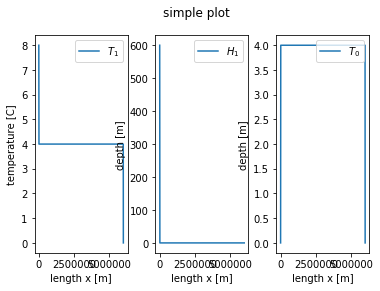

In [12]:
x=np.linspace(0,steps*Dx,steps)

plt.subplot(131)
plt.plot(x, T_1, label='$T_1$')
plt.xlabel('length x [m]')
plt.ylabel('temperature [C]')
plt.legend(loc='upper right')
plt.subplot(132)
plt.plot(x, H_1, label='$H_1$')
plt.xlabel('length x [m]')
plt.ylabel('depth [m]')
plt.legend(loc='upper right')
plt.subplot(133)
plt.plot(x, T_0, label='$T_0$')
plt.xlabel('length x [m]')
plt.ylabel('depth [m]')
plt.legend(loc='upper right')
plt.suptitle('simple plot')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.show()
#plt.savefig('simpleplot.png', dpi=300, bbox_inches='tight')